In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
data/Neutral
data/Calm
data/Happy
data/Sad
data/Angry
data/Fearful
data/Disgust
data/Surprised


In [1]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=2048, num_workers=2)
print(len(data_loaders['train']))

Dataset mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])
626


In [2]:
images, labels=next(iter(data_loaders['train']))
len(labels.unique())

863

In [3]:
len(labels)

1024

In [3]:

visualize_one_batch(data_loaders)

In [1]:
batch_size = 1024  # size of the minibatch for stochastic gradient descent (or Adam)
num_epochs = 25      # number of epochs for training
num_classes = 1000       # number of classes. Do not change this
learning_rate = 0.05  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.001     # regularization. Increase this to combat overfitting
momentum=0.8             

In [2]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel3
import torch
# get the data loaders using batch_size and valid_size defined in the previous
# cell
# HINT: do NOT copy/paste the values. Use the variables instead
data_loaders = get_data_loaders(batch_size=batch_size)
torch.backends.cuda.matmul.allow_tf32=True
torch.backends.cudnn.allow_tf32=True
# instance model MyModel with num_classes and drouput defined in the previous
# cell
model = MyModel3(num_classes=num_classes)
model.load_state_dict(torch.load('checkpoints/M3_best_val_loss.pt'))

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model, optimizer=opt, learning_rate=learning_rate,momentum=momentum,weight_decay=weight_decay)

Dataset mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])


In [3]:

# Get the loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/M3_best_val_loss.pt",
    run_logs=True,
    patience=2
)

Training:   0%|                                        | 0/1252 [00:00<?, ?it/s]

In [3]:

from src.train import one_epoch_test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|████████████████████████████████| 144/144 [00:13<00:00, 10.40it/s]

Test Loss: 0.160225


Test Accuracy: 91% (4188/4600)


0.1602245857163023

In [5]:
torch.save(model.state_dict(),'checkpoints/v2_best_val_loss.pt')

In [1]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel4
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes


# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel4(num_classes=1).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

model.load_state_dict(torch.load('checkpoints/v4_best_val_loss.pt'))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()


# dummy_input = torch.zeros(1,3,256,256)
# # inputs = ['images']
# # outputs = ['scores']
# # dynamic_axes= {'input':{0:'batch_size' , 2:'width', 3:'height'}, 'output':{0:'batch_size' , 2:'width', 3:'height'}}
# torch.onnx.export(predictor, dummy_input, 'model.onnx', verbose=True)


# Export using torch.jit.script
scripted_predictor =torch.jit.script(predictor) 

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4690, 0.3993, 0.3567]), std: tensor([0.3180, 0.3058, 0.3087])
Reusing cached mean and std


/home/naif/miniconda3/envs/MLenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/naif/miniconda3/envs/MLenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

  0%|                                          | 1/1819 [00:00<03:16,  9.26it/s]/home/naif/miniconda3/envs/MLenv/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %373 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664405705473/work/torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
100%|███████████████████████████████████████| 1819/1819 [00:38<00:00, 47.69it/s]

Accuracy: 0.8834524463991204


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

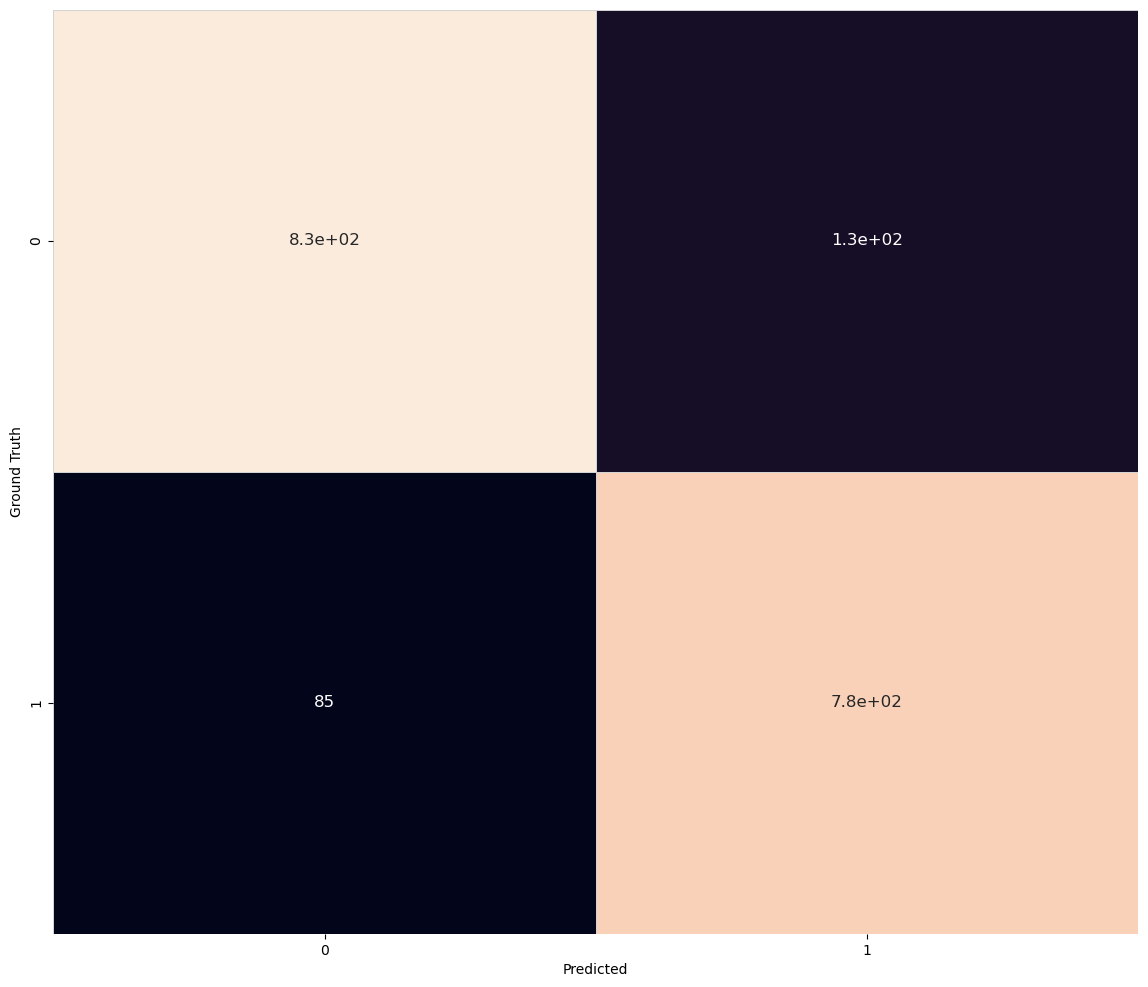

In [15]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)